# Forecast de Ventas 2026: Análisis por Tipo de Suscripción

**Objetivo:** Generar una proyección diaria de ventas (cantidad y/o ingresos) para el año 2026 basada en el histórico Agosto 2022 - Agosto 2025.

**Metodología:** Se utilizará el algoritmo **Prophet** (Meta), ideal para series de tiempo con fuerte estacionalidad y efectos de calendario.

**Datos de entrada:**
- Granularidad: Diaria
- Segmentación: `tipo_suscripcion`

In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics

# Configuración visual para los gráficos
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-light.mplstyle')
plt.rcParams['figure.figsize'] = (15, 6)

print("Librerías cargadas correctamente.")

Librerías cargadas correctamente.


In [132]:
# 1. Cargar el dataset
# Asegúrate de que el archivo esté en la misma carpeta o coloca la ruta completa
nombre_archivo = '../data/data_forecast_2025_silver/ingresos_membresia_anual_limpio.csv'  # <--- CAMBIA ESTO POR TU ARCHIVO REAL
df_main = pd.read_csv(nombre_archivo)

# 2. Conversión de fechas
df_main['fecha'] = pd.to_datetime(df_main['fecha'])

# 3. Verificación rápida
print(f"Rango de fechas: {df_main['fecha'].min()} a {df_main['fecha'].max()}")

display(df_main.head())

Rango de fechas: 2022-07-28 00:00:00 a 2024-12-31 00:00:00


,cantidad_Vendida,ingresos_totales_reales,fecha,ingresos_totales_reales_imputado
0,1,521.0,2022-07-28,521.0
1,1,521.0,2022-07-29,521.0
2,1,521.0,2022-08-02,521.0
3,2,1042.0,2022-08-07,1042.0
4,1,521.0,2022-08-10,521.0


Filtro para obtener muestra de datos

In [133]:
# *** PASO CRÍTICO: RENOMBRAR COLUMNAS ***
# Supongamos que tu csv tiene 'Fecha_Venta' y 'Total_Vendido'
df = df_main.rename(columns={'fecha': 'ds', 'ingresos_totales_reales_imputado': 'y'})

# Asegurar que 'ds' sea datetime
df['ds'] = pd.to_datetime(df['ds'])

Paso 3: Configurar y Entrenar el Modelo
- Aquí instanciamos la clase Prophet. Puedes agregar configuraciones extra aquí (como festivos).

Nota: Usé seasonality_mode='multiplicative' porque en ventas, cuando la tendencia crece, la estacionalidad suele crecer proporcionalmente (vendes más en Navidad año con año si tu empresa crece).

In [134]:
""" # Inicializar el modelo
# daily_seasonality=True si tienes datos por hora/minuto, si es por día, Prophet lo detecta solo.
m = Prophet(seasonality_mode='multiplicative') 

# Añadir festivos (Opcional pero recomendado para ventas)
m.add_country_holidays(country_name='MX') # Código de país (ej. MX, US, ES)

# Entrenar el modelo (Ajustar a los datos históricos)
m.fit(df) """

# Configuración personalizada para ventas volátiles
m = Prophet(
    changepoint_prior_scale=0.18,  # Hacemos la tendencia más flexible (detecta cambios rápidos)
    seasonality_prior_scale=15.0,  # Damos más peso a la estacionalidad
    seasonality_mode='multiplicative', # Las oscilaciones crecen si el negocio crece
    daily_seasonality=False,       # Apagamos estacionalidad diaria si solo tenemos datos por día
    yearly_seasonality=True        # Forzamos que busque patrones anuales
)

m.add_country_holidays(country_name='MX')
m.fit(df)


13:27:31 - cmdstanpy - INFO - Chain [1] start processing
13:27:31 - cmdstanpy - INFO - Chain [1] done processing


Paso 4: Crear el DataFrame Futuro
- Necesitamos crear una tabla vacía con las fechas futuras que queremos predecir.

In [135]:
# Crear fechas futuras para 365 días (1 año)
future = m.make_future_dataframe(periods=365, freq='D')

# Ver las últimas filas para confirmar que llegamos al futuro
print(future.tail())

             ds
1239 2025-12-27
1240 2025-12-28
1241 2025-12-29
1242 2025-12-30
1243 2025-12-31


Paso 5: Realizar la Predicción (Forecast)

In [136]:
# Predecir
forecast = m.predict(future)

# El resultado 'forecast' es un dataframe con muchas columnas.
# Nos interesan: 'ds', 'yhat' (predicción), 'yhat_lower' y 'yhat_upper' (intervalos de confianza)
print(forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail())

             ds           yhat     yhat_lower     yhat_upper
1239 2025-12-27  185885.628344  141482.866057  231374.682422
1240 2025-12-28  219559.105878  170357.238510  265853.875505
1241 2025-12-29  188430.811148  142937.421268  234509.815963
1242 2025-12-30  195078.767741  148423.739210  245213.782024
1243 2025-12-31  197255.841707  146946.167440  244744.310476


Paso 6: Visualización
- Prophet tiene herramientas de visualización integradas que son excelentes.

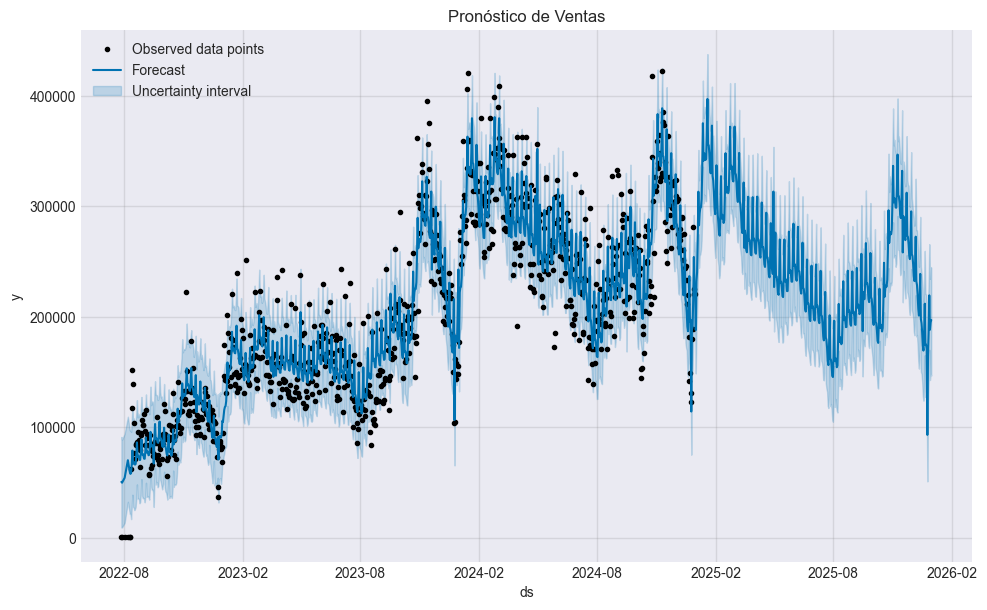

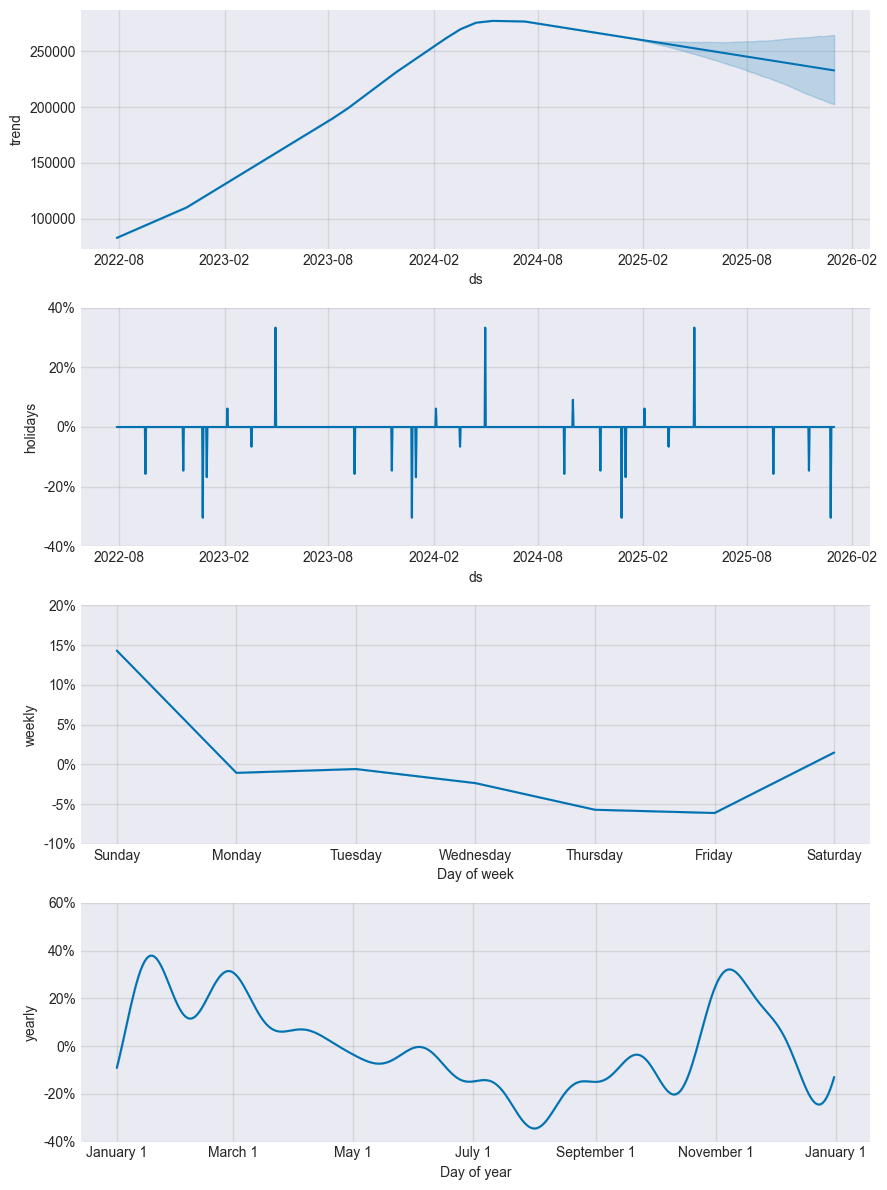

In [137]:
# 1. Gráfico principal: Puntos negros son datos reales, línea azul es la predicción
fig1 = m.plot(forecast)
plt.title("Pronóstico de Ventas")
# mostrar leyenda
plt.legend()
plt.show()

# 2. Desglose de componentes: Muestra Tendencia, Semanal, Anual y Festivos por separado
fig2 = m.plot_components(forecast)
plt.show()

##### Agrupamos data por mes para su exportacion

In [138]:
# agrupar por mes y sumar yhat, yhat_lower, yhat_upper
forecast['ds'] = pd.to_datetime(forecast['ds'])
forecast['month'] = forecast['ds'].dt.to_period('M')
monthly_sales = forecast.groupby('month')[['yhat', 'yhat_lower', 'yhat_upper']].sum().round(2).reset_index()
print(monthly_sales)

      month        yhat  yhat_lower   yhat_upper
0   2022-07   100854.02    19040.44    180407.21
1   2022-08  1701700.34   767931.90   2633078.25
2   2022-09  2542460.41  1364046.05   3723929.79
3   2022-10  2918276.37  1703043.70   4141150.66
4   2022-11  3981784.98  2798827.34   5162705.94
5   2022-12  3146342.08  1926138.96   4359976.01
6   2023-01  4796676.61  3590691.03   6006558.92
7   2023-02  4551883.25  3465319.82   5641461.64
8   2023-03  5100073.85  3882490.80   6312459.32
9   2023-04  4789616.16  3623184.66   5960619.49
10  2023-05  4845671.85  3633132.73   6059532.55
11  2023-06  4780210.41  3615853.48   5964590.43
12  2023-07  4466321.97  3255683.83   5674426.95
13  2023-08  4596509.70  3368672.56   5803393.99
14  2023-09  5521911.99  4349974.69   6690364.16
15  2023-10  6213215.72  4991296.58   7428110.43
16  2023-11  8401876.00  7228651.06   9556707.66
17  2023-12  6521640.69  5317912.44   7738384.44
18  2024-01  9422372.23  8205456.77  10634757.06
19  2024-02  9056264

In [139]:
monthly_sales.to_csv("../data/data_forecast_2025_gold/forecast_anual_2025_monthly.csv")

In [140]:
df_cv = cross_validation(m, initial='730 days', period='180 days', horizon='90 days')

# 2. Calcular métricas de error
df_p = performance_metrics(df_cv)

# 3. Ver el resultado (Las métricas más importantes)
print(df_p[['horizon', 'rmse', 'mape']].head())

  0%|          | 0/1 [00:00<?, ?it/s]13:27:33 - cmdstanpy - INFO - Chain [1] start processing
13:27:33 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 1/1 [00:00<00:00,  2.35it/s]

  horizon          rmse      mape
0  9 days  58396.882366  0.284453
1 10 days  60619.284021  0.304835
2 11 days  75989.331485  0.387763
3 12 days  77775.196474  0.408811
4 13 days  75654.956086  0.388363
